In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as f

In [2]:
n_per_cluster = 100
blur = 1.1

A = [1, 1]
B = [2, 6]
C = [5, 2]
D = [6, 6]

a = [A[0] + np.random.randn(n_per_cluster) * blur, A[1] + np.random.randn(n_per_cluster) * blur]
b = [B[0] + np.random.randn(n_per_cluster) * blur, B[1] + np.random.randn(n_per_cluster) * blur]
c = [C[0] + np.random.randn(n_per_cluster) * blur, C[1] + np.random.randn(n_per_cluster) * blur]
d = [D[0] + np.random.randn(n_per_cluster) * blur, D[1] + np.random.randn(n_per_cluster) * blur]

labels_np = np.vstack(
    (np.zeros((n_per_cluster, 1)),
     np.ones((n_per_cluster, 1)),
     np.full((n_per_cluster, 1), 2),
     np.full((n_per_cluster, 1), 3))
)

data_np = np.hstack((a, b, c, d)).T

data = torch.tensor(data_np).float()
labels = (torch.tensor(labels_np).long()).squeeze()

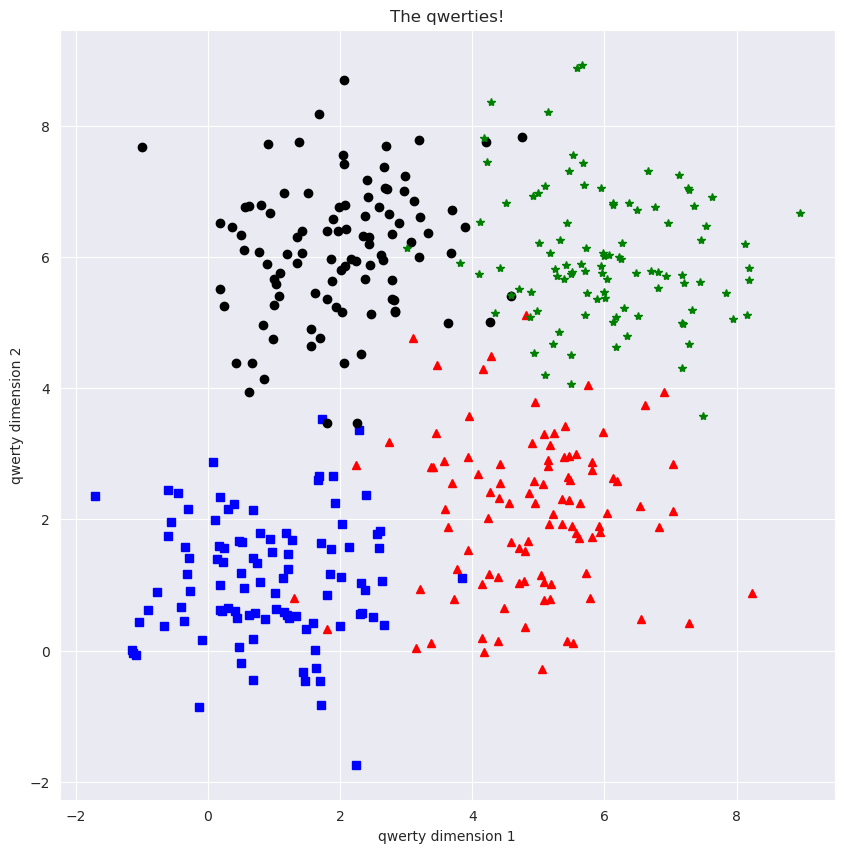

In [3]:
fig = plt.figure(figsize=(10, 10))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], "bs")
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], "ko")
plt.plot(data[np.where(labels == 2)[0], 0], data[np.where(labels == 2)[0], 1], "r^")
plt.plot(data[np.where(labels == 3)[0], 0], data[np.where(labels == 3)[0], 1], "g*")
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [5]:
class ANNModel(nn.Module):

    def __init__(self, n_units, n_layers):
        super().__init__()

        self.layers = nn.ModuleDict()
        self.n_layers = n_layers

        self.layers["input"] = nn.Linear(2, n_units)

        for i in range(2):
            self.layers[f"hidden_{i}"] = nn.Linear(n_units, n_units)

        self.layers["output"] = nn.Linear(n_units, 4)

    def forward(self, input):
        output = f.relu(self.layers["input"](input))

        for i in range(self.n_layers):
            output = f.relu(self.layers[f"hidden_{i}"](output))

        output = self.layers["output"](output)

        return output

In [6]:
def train(model, lr, epochs):
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=.005)
    losses = torch.zeros(epochs)
    ongoing_acc = []

    for epoch in range(epochs):
        output = model(data)

        loss = loss_func(output, labels)
        losses[epoch] = loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        matches = torch.argmax(output, dim=1) == labels
        matches_numeric = matches.float()
        acc_percent = 100 * torch.mean(matches_numeric)
        ongoing_acc.append(acc_percent)

    preds = model(data)

    preds_labels = torch.argmax(preds, dim=1)

    matches = preds_labels == labels
    matches_float = matches.float()
    total_acc = 100 * torch.mean(matches_float)

    return preds, losses, ongoing_acc, total_acc

In [8]:
preds, losses, ongoing_acc, total_acc = train(ANNModel(8, 2), .005, 10000)

Final accuracy: 95.5%


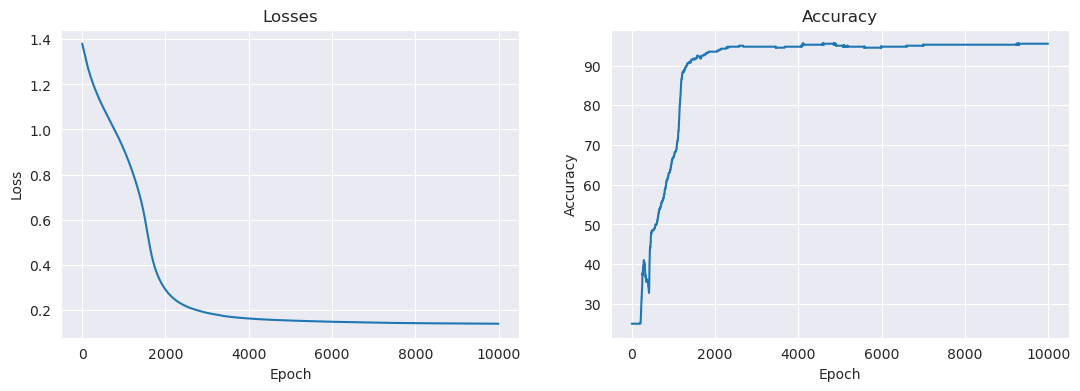

In [9]:
print("Final accuracy: %g%%" % total_acc)

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

ax[0].plot(losses.detach())
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Losses")

ax[1].plot(ongoing_acc)
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Accuracy")
plt.show()

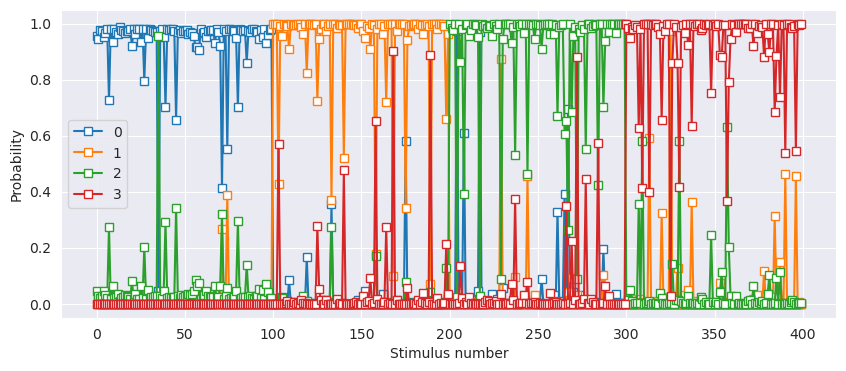

In [10]:
sm = nn.Softmax(1)
fig = plt.figure(figsize=(10, 4))

plt.plot(sm(preds).detach().numpy(), "s-", markerfacecolor="w")
plt.xlabel("Stimulus number")
plt.ylabel("Probability")
plt.legend(["0", "1", "2", "3"])
plt.show()